In [ ]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
project_dir = "../braintypicality"
sys.path.append(project_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
# import functools
import glob
import re
# import math
import torch
import ants
import antspynet
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# from matplotlib import ticker
# import matplotlib as mpl
# import matplotlib.colors as mcolors


# from functools import partial
# from scipy.ndimage import median_filter
# import skimage.filters as skf
from scipy.stats import percentileofscore

import yaml
from nilearn import datasets, plotting
import os 

In [ ]:
CACHE_DIR = "../braintypicality/dataset/template_cache"

procd_ref_img_path = f"{CACHE_DIR}/cropped_niral_mni.nii.gz"

# if not os.path.exists(procd_ref_img_path):
T1_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a.nrrd"
)
T2_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t2_tal_nlin_sym_09a.nrrd"
)
MASK_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a_mask.nrrd"
)

ants_mni = ants.image_read(f"{CACHE_DIR}/croppedMni152.nii.gz")
t1_ref_img = ants.image_read(T1_REF_IMG_PATH)
t2_ref_img = ants.image_read(T2_REF_IMG_PATH)
ref_img_mask = ants.image_read(MASK_REF_IMG_PATH)

# Use ANTs' tighter cropping
diff = np.array(t1_ref_img.shape) - np.array(ants_mni.shape)
crop_idxs_start, crop_idxs_end = 1 + diff // 2, np.array(t1_ref_img.shape) - diff // 2

t1_ref_img = ants.crop_indices(t1_ref_img, crop_idxs_start, crop_idxs_end)
t2_ref_img = ants.crop_indices(t2_ref_img, crop_idxs_start, crop_idxs_end)
ref_img_mask = ants.crop_indices(ref_img_mask, crop_idxs_start, crop_idxs_end)

procd_ref_img = ants.merge_channels((t1_ref_img * ref_img_mask, t2_ref_img * ref_img_mask))
procd_ref_img.to_filename(procd_ref_img_path)

In [ ]:
def register_to_mni(x:np.ndarray, fname: str, transforms_dir: str, ref_img_post_transform=ref_img_post_transform):
    x = ants.from_numpy(x)
    sampleid = os.path.basename(fname).split(".nii.gz")[0]
    transform_mat = f"{transforms_dir}/{sampleid}Composite.h5"
    return ants.apply_transforms(
        fixed=ref_img_post_transform, interpolator="linear", verbose=False,
        moving=x, transformlist=transform_mat
    ).numpy()

In [159]:
# @jit(nopython=True)
def count(x):
    return np.count_nonzero(x, axis=0)

# @jit(nopython=True)
def vec_pscore(score, reference_scores):
    """
    Computes the percentile of a given tensor x at each position with respect to a reference tensor
    Args:
        x: Tensor of shape (b, h, w, d)
        reference_scores: Tensor of shape (b, h, w, d)
    Returns:
        percentiles: Tensor of shape (b, h, w, d)
    """

    n = reference_scores.shape[0]
    
    # Prepare broadcasting
    reference_scores = reference_scores[:, None, ...]

    left = count(reference_scores < score)
    right = count(reference_scores <= score)
    plus1 = left < right
    perct = (left + right + plus1) * (50.0 / n)
    return perct

In [ ]:
#from sade.configs.flows import ve_flow_config as configs
from sade.configs.flows import ve_flow_config_abcd_asd as configs
from sade.datasets.loaders import get_image_files_list, get_val_transform, get_lesion_transform
from sade.metrics import erode_brain_masks

config = configs.get_config()
config.msma.denoise=False
config.msma.schedule = "geometric"
config.model.learnable_embedding=True
workdir = "../braintypicality/workdir/cuda_opt/learnable"
transforms_dir = f"/BEE/Connectome/ABCD/Users/amahmood/braintyp/spacing_{int(config.data.spacing_pix_dim)}"
transforms_dir_conte = f"/BEE/Connectome/ABCD/Users/amahmood/braintyp/spacing_{int(config.data.spacing_pix_dim)}-ants"
transforms_dir_abcd_asd = f"/BEE/Connectome/ABCD/Users/emre/braintyp/spacing_2-ants"
unscale = lambda x: (x+1)/2

img_loader = get_val_transform(config)
img_and_label_loader = get_lesion_transform(config)

procd_ref_img_path = f"{CACHE_DIR}/cropped_niral_mni.nii.gz"
ref_img_tensor = img_loader({"image": procd_ref_img_path})["image"].numpy()
ref_img_post_transform = unscale(ants.from_numpy(ref_img_tensor[0]))

print("int(config.data.spacing_pix_dim)",int(config.data.spacing_pix_dim))

int(config.data.spacing_pix_dim) 2


In [161]:
bmask = (ref_img_post_transform.numpy() > 0).astype(float)
BRAIN_MASK = ants.from_numpy(bmask)
# ERODED_BRAIN_MASK = ants.from_numpy(erode_brain_masks(BRAIN_MASK[None,...].numpy(),radius=2)[0])

In [162]:
np.unique(bmask)

array([0., 1.])

### Load the data

In [ ]:
dataset_dir = "/BEE/Connectome/ABCD/Users/amahmood/braintyp/processed_v2"
dataset_dir_abcd_asd = "/BEE/Connectome/ABCD/Users/emre/braintyp/processed_v3"
# Directory that holds files with train/test splits and other filenames
# splits_dir = config.data.splits_dir
splits_dir = "../asd-preprocessing/identifier_keys/split-keys"
config.data, dataset_dir, "\n",  splits_dir


(cache_rate: 0.0
 dataset: ABCD
 dir_path: /BEE/Connectome/ABCD/Users/amahmood/braintyp/processed_v2/
 image_size: !!python/tuple
 - 96
 - 112
 - 80
 num_channels: 2
 spacing_pix_dim: 2.0
 splits_dir: /ASD2/emre_projects/OOD/scripts/braintypicality-scripts/split-keys/,
 '/BEE/Connectome/ABCD/Users/amahmood/braintyp/processed_v2',
 '\n',
 '/ASD2/emre_projects/OOD/scripts/braintypicality-scripts/split-keys')

In [164]:
# preprocessed image paths.

abcd_train_files = get_image_files_list("abcd-train", dataset_dir, splits_dir)
abcd_val_files = get_image_files_list("abcd-val", dataset_dir, splits_dir)
abcd_test_files = get_image_files_list("abcd-test", dataset_dir, splits_dir)
abcd_asd_files = get_image_files_list("abcd-asd", dataset_dir_abcd_asd, splits_dir)
abcd_val_test_files = abcd_val_files + abcd_test_files

ibis_inlier_files = get_image_files_list("ibis-inlier", dataset_dir, splits_dir)
ibis_ds_files = get_image_files_list("ibis-ds-sa", dataset_dir, splits_dir)
ibis_hr_files = get_image_files_list("ibis-hr-inliers", dataset_dir, splits_dir)
ibis_atyp_files = get_image_files_list("ibis-atypical", dataset_dir, splits_dir)
ibis_asd_files = get_image_files_list("ibis-asd", dataset_dir, splits_dir)

conte_files = get_image_files_list("conte", dataset_dir, splits_dir)

In [165]:
print('abcd_train_files:\t',len(abcd_train_files))
print('abcd_val_files:\t\t',len(abcd_val_files))
print('abcd_test_files:\t',len(abcd_test_files))
print('abcd_val_test_files:\t',len(abcd_val_test_files))
print('abcd_asd_files:\t\t',len(abcd_asd_files))
print('ibis_inlier_files:\t',len(ibis_inlier_files))
print('ibis_ds_files:\t\t',len(ibis_ds_files))
print('ibis_hr_files:\t\t',len(ibis_hr_files))
print('ibis_atyp_files:\t',len(ibis_atyp_files))
print('ibis_asd_files:\t\t',len(ibis_asd_files))
print('conte_files:\t\t',len(conte_files))

abcd_train_files:	 1320
abcd_val_files:		 165
abcd_test_files:	 165
abcd_val_test_files:	 330
abcd_asd_files:		 161
ibis_inlier_files:	 82
ibis_ds_files:		 28
ibis_hr_files:		 106
ibis_atyp_files:	 38
ibis_asd_files:		 65
conte_files:		 444


In [166]:
extract_ids = lambda f: f.split("/")[-1].replace('.nii.gz', '')
extract_ids(ibis_ds_files[0]["image"])

'IBIS105477'

In [167]:
len(abcd_train_files)

1320

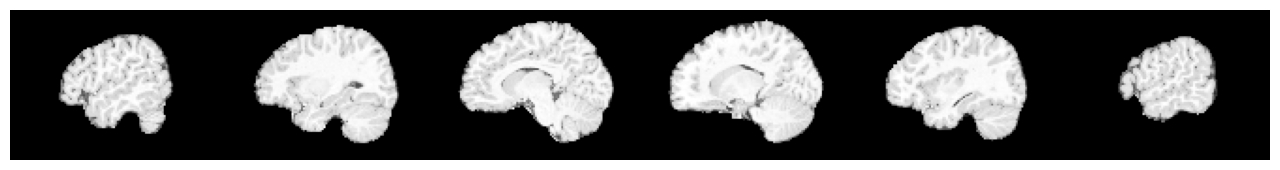

In [168]:
fname = abcd_asd_files[1]["image"]
img_tensor = img_loader({"image": fname})["image"].numpy()
t1 = unscale(ants.from_numpy(img_tensor[0]))
t1.plot(nslices=6)

In [170]:
transforms_dir

'/BEE/Connectome/ABCD/Users/amahmood/braintyp/spacing_2'

In [171]:
fname

'/BEE/Connectome/ABCD/Users/emre/braintyp/processed_v3/NDARINV03KMHMJJ.nii.gz'

['-d', '3', '-i', '0x7f0c3813cee8', '-o', '0x7f0c380ab5c8', '-r', '0x7f0c3813c0c8', '-n', 'linear', '-t', '/BEE/Connectome/ABCD/Users/emre/braintyp/spacing_2-ants/NDARINV03KMHMJJComposite.h5']
Using double precision for computations.
Input scalar image: 0x7f0c3813cee8
Could not create ImageIO for the input file, assuming dimension = 3 and scalar pixel type
Reference image: 0x7f0c3813c0c8
The composite transform comprises the following transforms (in order): 
  1. /BEE/Connectome/ABCD/Users/emre/braintyp/spacing_2-ants/NDARINV03KMHMJJComposite.h5[0] (type = AffineTransform)
  2. /BEE/Connectome/ABCD/Users/emre/braintyp/spacing_2-ants/NDARINV03KMHMJJComposite.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: 0x7f0c380ab5c8


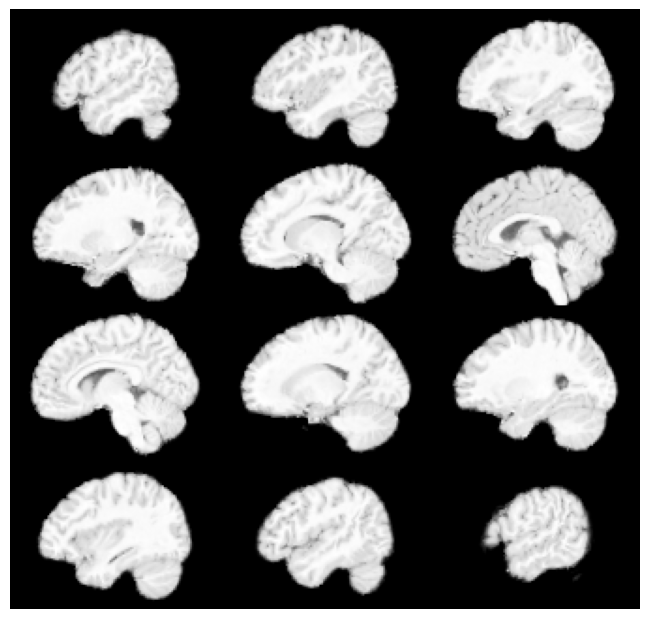

In [ ]:
sampleid = os.path.basename(fname).split(".nii.gz")[0]
transform_mat = f"{transforms_dir_abcd_asd}/{sampleid}Composite.h5"
t1_reg = ants.apply_transforms(
        fixed=ref_img_post_transform, moving=t1,
        transformlist=transform_mat, interpolator="linear",verbose=True
)
t1_reg.plot()

In [ ]:
# flow_path = '/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/flow/psz3-globalpsz17-nb20-lr0.0003-bs32-np1024-kimg200_nb20_long/eval/ckpt_6040/'
flow_path = '../braintypicality/workdir/cuda_opt/learnable/flow/psz3-globalpsz17-nb20-lr0.0003-bs32-np1024-kimg300_smin1e-2_smax0.8/eval/ckpt_9240'
#flow_path = '/ASD2/emre_projects/OOD/braintypicality2/braintypicality/workdir/cuda_opt/learnable/flow/psz3-globalpsz17-nb20-lr0.0003-bs32-np1024-kimg300_smin1e-2_smax0.8/eval/ckpt_9240'
%ls $flow_path

/ASD2/emre_projects/miniconda3/envs/myenv/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=4135827) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


abcd-test_lesion_load_20-enhanced_results.npz
abcd-test_lesion_load_20-enhanced_seg_eval.csv
abcd-test_lesion_load_20-enhanced_segs.npz
abcd-val_lesion_load_20_results.npz
ibis-hr-inlier_ibis-ds-sa_results.npz
ibis-inlier_ibis-asd_results.npz
ibis-inlier_ibis-atypical_results.npz


In [174]:
abcd_asd_files[1]

{'image': '/BEE/Connectome/ABCD/Users/emre/braintyp/processed_v3/NDARINV03KMHMJJ.nii.gz'}

In [ ]:
exx = np.load("../braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct/abcd-asd/NDARINV0182J779.npz")

In [177]:
exx

NpzFile '/ASD2/emre_projects/OOD/braintypicality2/braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct/abcd-asd/NDARINV0182J779.npz' with keys: original, heatmap, scores, score_norms

In [178]:
exx['heatmap'].shape

(96, 112, 80)

## load heatmaps directly

In [ ]:
workdir = "../braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct/"
#dataset = "ibis-ds-sa"
# dataset = "ibis-asd"
dataset = "abcd-asd"
dataset_val = "abcd-val"
dataset_test = "abcd-test"
fnames = glob.glob(f"{workdir}/{dataset}/*")
fnames_val = glob.glob(f"{workdir}/{dataset_val}/*")
fnames_test = glob.glob(f"{workdir}/{dataset_test}/*")
print(fnames[0], "\n", fnames_val[0], "\n", fnames_test[0])

fnames_val = fnames_val + fnames_test

/ASD2/emre_projects/OOD/braintypicality2/braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct//abcd-asd/NDARINV0182J779.npz 
 /ASD2/emre_projects/OOD/braintypicality2/braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct//abcd-val/NDARINV2AVRCTAA.npz 
 /ASD2/emre_projects/OOD/braintypicality2/braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct//abcd-test/NDARINV35LVTJCY.npz


In [181]:
def load_split_keys(splits_dir: str, cohort_name: str):
    """
    Reads the split‐keys file for the given cohort from `splits_dir` and returns
    a list of subject IDs (one per line in the file).
    
    It supports files named either:
      - `<cohort_name>.txt`
      - `<cohort_name>_keys.txt`
    or, if neither is found, picks the first file whose name contains `cohort_name`.
    
    Args:
        splits_dir:   Path to the directory containing your split‐keys text files.
        cohort_name:  Name of the cohort whose key file you want to load
                      (e.g. "abcd-val", "ibis-asd", etc.).
    
    Returns:
        A list of subject ID strings, in the same order they appear in the file.
    
    Raises:
        FileNotFoundError: if no matching key file is found in `splits_dir`.
    """
    # 1) List all files in the splits directory
    files = os.listdir(splits_dir)

    # 2) Look for exact-named files first
    candidates = {f"{cohort_name}.txt", f"{cohort_name}_keys.txt"}
    matches = [f for f in files if f in candidates]

    # 3) Fallback: any file containing the cohort_name substring
    if not matches:
        matches = [f for f in files if cohort_name.lower() in f.lower()]

    if not matches:
        raise FileNotFoundError(
            f"No key file found for cohort '{cohort_name}' in directory: {splits_dir}"
        )

    # 4) Pick the first match
    key_path = os.path.join(splits_dir, matches[0])

    # 5) Read and return non-empty, stripped lines
    with open(key_path, 'r') as fp:
        subject_ids = [line.strip() for line in fp if line.strip()]

    return subject_ids

In [182]:
sids_abcd_test = load_split_keys(splits_dir, "abcd-test")
sids_abcd_val = load_split_keys(splits_dir, "abcd-val")
sids_abcd_asd = load_split_keys(splits_dir, "abcd-asd")
sids_ibis_asd = load_split_keys(splits_dir, "ibis-asd")
sids_ibis_atypical = load_split_keys(splits_dir, "ibis-atypical")
sids_ibis_ds = load_split_keys(splits_dir, "ibis-ds-sa")
sids_ibis_inlier = load_split_keys(splits_dir, "ibis-inlier")
sids_ibis_hr_inlers = load_split_keys(splits_dir, "ibis-hr-inliers")
sids_conte = load_split_keys(splits_dir, "conte")

In [183]:
def load_registered_heatmaps_from_files(workdir, dataset):

    fnames_registered_heatmaps = glob.glob(f"{workdir}/registered-heatmaps-{dataset}/*")

    # Load test images and store sample IDs
    registered_heatmaps = []
    loaded_sids = []
    for f in fnames_registered_heatmaps:
        sid = re.match(r".*\/(.*)(\.npz|\.nii.gz)", f).group(1)
        #registered_heatmap_path = f"{workdir}/registered-heatmaps-{dataset}/{sid}.nii.gz"
        if os.path.exists(f):
            registered_heatmap = ants.image_read(f)
            registered_heatmaps.append(registered_heatmap)
            loaded_sids.append(sid)
    return registered_heatmaps, loaded_sids

In [184]:
def load_registered_heatmaps_from_sids(workdir, dataset, sids):

    # Load test images and store sample IDs
    registered_heatmaps = []
    loaded_sids = []
    for sid in sids:
        f = f"{workdir}/registered-heatmaps-{dataset}/{sid}.nii.gz"
        if os.path.exists(f):
            registered_heatmap = ants.image_read(f)
            registered_heatmaps.append(registered_heatmap)
            loaded_sids.append(sid)
    return registered_heatmaps, loaded_sids

In [186]:
registered_heatmaps_abcd_val_test, sids_abcd_val_test = load_registered_heatmaps_from_files(workdir, "val-test")
registered_heatmaps_abcd_asd, sids_abcd_asd = load_registered_heatmaps_from_files(workdir, "abcd-asd")
registered_heatmaps_ibis_asd, sids_ibis_asd = load_registered_heatmaps_from_files(workdir, "ibis-asd")
registered_heatmaps_ibis_atypical, sids_ibis_atypical = load_registered_heatmaps_from_files(workdir, "ibis-atypical")
registered_heatmaps_ibis_ds, sids_ibis_ds = load_registered_heatmaps_from_files(workdir, "ibis-ds-sa")
registered_heatmaps_ibis_inlier, sids_ibis_inlier = load_registered_heatmaps_from_files(workdir, "ibis-inlier")
registered_heatmaps_hr_inlers, sids_hr_inlers = load_registered_heatmaps_from_files(workdir, "ibis-hr-inliers")
registered_heatmaps_conte, sids_conte = load_registered_heatmaps_from_files(workdir, "conte")

In [187]:
registered_heatmaps_abcd_val_test_np_list = [img.numpy() for img in registered_heatmaps_abcd_val_test]
registered_heatmaps_abcd_val_test_np = np.stack(registered_heatmaps_abcd_val_test_np_list, axis=0)

registered_heatmaps_abcd_asd_np_list = [img.numpy() for img in registered_heatmaps_abcd_asd]
registered_heatmaps_abcd_asd_np = np.stack(registered_heatmaps_abcd_asd_np_list, axis=0)

registered_heatmaps_ibis_asd_np_list = [img.numpy() for img in registered_heatmaps_ibis_asd]
registered_heatmaps_ibis_asd_np = np.stack(registered_heatmaps_ibis_asd_np_list, axis=0)

registered_heatmaps_ibis_atypical_np_list = [img.numpy() for img in registered_heatmaps_ibis_atypical]
registered_heatmaps_ibis_atypical_np = np.stack(registered_heatmaps_ibis_atypical_np_list, axis=0)

registered_heatmaps_ibis_ds_np_list = [img.numpy() for img in registered_heatmaps_ibis_ds]
registered_heatmaps_ibis_ds_np = np.stack(registered_heatmaps_ibis_ds_np_list, axis=0)

registered_heatmaps_ibis_inlier_np_list = [img.numpy() for img in registered_heatmaps_ibis_inlier]
registered_heatmaps_ibis_inlier_np = np.stack(registered_heatmaps_ibis_inlier_np_list, axis=0)

registered_heatmaps_ibis_hr_inlers_np_list = [img.numpy() for img in registered_heatmaps_hr_inlers]
registered_heatmaps_ibis_hr_inlers_np = np.stack(registered_heatmaps_ibis_hr_inlers_np_list, axis=0)

registered_heatmaps_conte_np_list = [img.numpy() for img in registered_heatmaps_conte]
registered_heatmaps_conte_np = np.stack(registered_heatmaps_conte_np_list, axis=0)

In [188]:
def load_registered_originals_from_files(workdir, dataset):

    fnames_registered_originals = glob.glob(f"{workdir}/registered-originals-{dataset}/*")

    # Load test images and store sample IDs
    registered_originals = []
    loaded_sids = []
    for f in fnames_registered_originals:
        sid = re.match(r".*\/(.*)(\.npz|\.nii.gz)", f).group(1)
        #registered_heatmap_path = f"{workdir}/registered-heatmaps-{dataset}/{sid}.nii.gz"
        if os.path.exists(f):
            registered_original = ants.image_read(f)
            registered_originals.append(registered_original)
            loaded_sids.append(sid)
    return registered_originals, loaded_sids

In [ ]:
def load_originals_from_files(workdir, dataset):

    fnames_originals = glob.glob(f"{workdir}/registered-originals-{dataset}/*")

    # Load test images and store sample IDs
    originals = []
    loaded_sids = []
    for f in fnames_originals:
        sid = re.match(r".*\/(.*)(\.npz|\.nii.gz)", f).group(1)
        if os.path.exists(f):
            if dataset == "abcd-asd":
                processed = ants.image_read(f"/BEE/Connectome/ABCD/Users/emre/braintyp/processed_v3/{sid}.nii.gz")
            else:
                processed = ants.image_read(f"/BEE/Connectome/ABCD/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz")
            originals.append(processed)
            loaded_sids.append(sid)
    return originals, loaded_sids

In [ ]:
def load_originals_from_files(workdir, dataset):
    
    print(dataset)
    fnames = glob.glob(f"{workdir}/{dataset}/*")
    fnames_originals = glob.glob(f"{workdir}/registered-originals-{dataset}/*")
    reprod_path = glob.glob(f"{workdir}/{dataset}/*")

    # Load test images and store sample IDs
    originals = []
    loaded_sids = []
    for f in fnames:
        sid = re.match(r".*\/(.*)(\.npz|\.nii.gz)", f).group(1)
        if os.path.exists(f):
            data = np.load(f)
            original = data['original']
            # if dataset == "abcd-asd":
            #     processed = ants.image_read(f"/BEE/Connectome/ABCD/Users/emre/braintyp/processed_v3/{sid}.nii.gz")
            # else:
            #     processed = ants.image_read(f"/BEE/Connectome/ABCD/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz")
            #registered_original = ants.image_read(f)
            originals.append(original)
            loaded_sids.append(sid)
    return originals, loaded_sids

In [192]:
originals_abcd_test, sids_abcd_test = load_originals_from_files(workdir, "abcd-test")
originals_abcd_val, sids_abcd_val = load_originals_from_files(workdir, "abcd-val")
originals_abcd_val_test = originals_abcd_val + originals_abcd_test
sids_abcd_val_test = sids_abcd_val + sids_abcd_test
originals_abcd_asd, sids_abcd_asd = load_originals_from_files(workdir, "abcd-asd")
originals_ibis_asd, sids_ibis_asd = load_originals_from_files(workdir, "ibis-asd")
originals_ibis_atypical, sids_ibis_atypical = load_originals_from_files(workdir, "ibis-atypical")
originals_ibis_ds, sids_ibis_ds = load_originals_from_files(workdir, "ibis-ds-sa")
originals_ibis_inlier, sids_ibis_inlier = load_originals_from_files(workdir, "ibis-inlier")
originals_hr_inlers, sids_hr_inlers = load_originals_from_files(workdir, "ibis-hr-inliers")
#originals_conte, sids_conte = load_originals_from_files(workdir, "conte")

abcd-test
abcd-val
abcd-asd
ibis-asd
ibis-atypical
ibis-ds-sa
ibis-inlier
ibis-hr-inliers


In [193]:
len(originals_abcd_val_test)

330

In [194]:
originals_abcd_val_test[0].shape

(2, 96, 112, 80)

In [196]:
print("1/7")
originals_abcd_val_test_np_list = [(img[0]+1)/2 for img in originals_abcd_val_test]
originals_abcd_val_test_np = np.stack(originals_abcd_val_test_np_list, axis=0)
print("2/7")
originals_abcd_asd_np_list = [(img[0]+1)/2 for img in originals_abcd_asd]
originals_abcd_asd_np = np.stack(originals_abcd_asd_np_list, axis=0)
print("3/7")
originals_ibis_asd_np_list = [(img[0]+1)/2 for img in originals_ibis_asd]
originals_ibis_asd_np = np.stack(originals_ibis_asd_np_list, axis=0)
print("4/7")
originals_ibis_atypical_np_list = [(img[0]+1)/2 for img in originals_ibis_atypical]
originals_ibis_atypical_np = np.stack(originals_ibis_atypical_np_list, axis=0)
print("5/7")
originals_ibis_ds_np_list = [(img[0]+1)/2 for img in originals_ibis_ds]
originals_ibis_ds_np = np.stack(originals_ibis_ds_np_list, axis=0)
print("6/7")
originals_ibis_inlier_np_list = [(img[0]+1)/2 for img in originals_ibis_inlier]
originals_ibis_inlier_np = np.stack(originals_ibis_inlier_np_list, axis=0)
print("7/7")
originals_ibis_hr_inlers_np_list = [(img[0]+1)/2 for img in originals_hr_inlers]
originals_ibis_hr_inlers_np = np.stack(originals_ibis_hr_inlers_np_list, axis=0)

# originals_conte_np_list = [img[0] for img in originals_conte]
# originals_conte_np = np.stack(originals_conte_np_list, axis=0)

1/7
2/7
3/7
4/7
5/7
6/7
7/7


In [197]:
originals_abcd_val_test_np.shape

(330, 96, 112, 80)

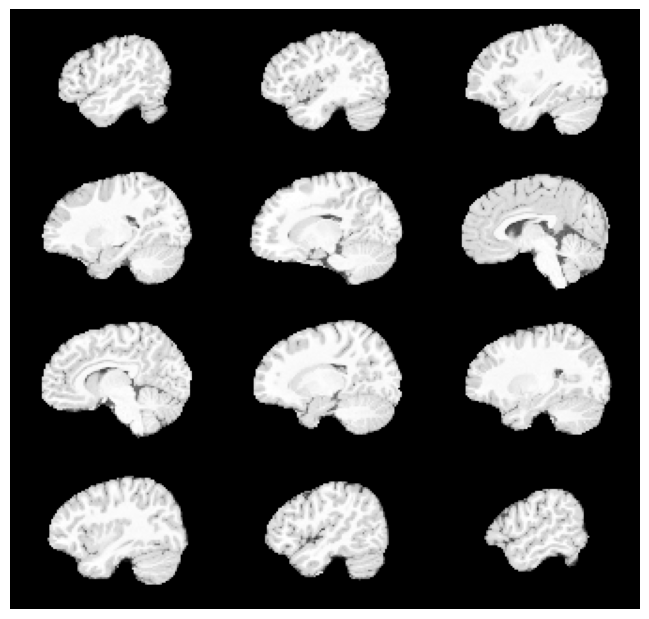

In [198]:
ants.from_numpy(originals_abcd_val_test_np[0]).plot()

In [199]:
originals_abcd_all = np.concatenate((originals_abcd_val_test_np, originals_abcd_asd_np), axis=0)
originals_ibis_all = np.concatenate((originals_ibis_asd_np, originals_ibis_atypical_np, originals_ibis_ds_np, originals_ibis_inlier_np, originals_ibis_hr_inlers_np), axis=0)
originals_abcd_all.shape, originals_ibis_all.shape

((491, 96, 112, 80), (319, 96, 112, 80))

In [200]:
np.mean(originals_abcd_all[originals_abcd_all > 0]),  np.mean(originals_ibis_all[originals_ibis_all > 0])
# (0.80020374, 0.7900173)

(0.80020374, 0.7900173)

In [201]:
np.min(originals_abcd_all[originals_abcd_all > 0]),  np.min(originals_ibis_all[originals_ibis_all > 0])
# (0.004750818, 0.005075097)

(0.004750818, 0.005075097)

In [202]:
np.max(originals_abcd_all[originals_abcd_all > 0]),  np.max(originals_ibis_all[originals_ibis_all > 0])
# (1.0, 1.0)

(1.0, 1.0)

In [203]:
np.median(originals_abcd_all[originals_abcd_all > 0]),  np.median(originals_ibis_all[originals_ibis_all > 0])
# (0.8276236, 0.79688144)

(0.8276236, 0.79688144)

In [204]:
np.min(originals_abcd_all),  np.min(originals_ibis_all)
# (0.0, 0.0)

(0.0, 0.0)

In [205]:
# count non-zero voxels
print("{:,}".format((~np.isnan(originals_abcd_all[originals_abcd_all > 0])).sum()//originals_abcd_all.shape[0]))
print("{:,}".format((~np.isnan(originals_ibis_all[originals_ibis_all > 0])).sum()//originals_ibis_all.shape[0]))
# 184,852
# 183,958

184,852
183,958


In [206]:
# count x <= zero voxels
print("{:,}".format((~np.isnan(originals_abcd_all[originals_abcd_all <= 0])).sum()//originals_abcd_all.shape[0]))
print("{:,}".format((~np.isnan(originals_ibis_all[originals_ibis_all <= 0])).sum()//originals_ibis_all.shape[0]))
# 675,307
# 676,201

675,307
676,201


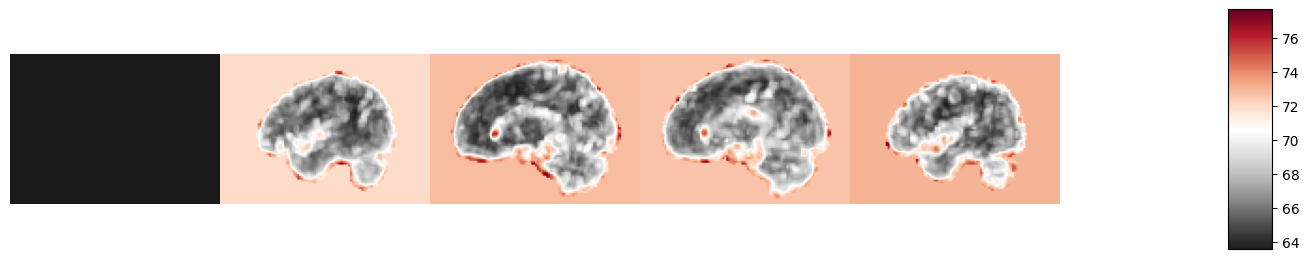

In [240]:
x = registered_heatmaps_abcd_val_test_np[30]
x = x - x.min()
x = ants.from_numpy(x)
x.plot(nslices=6, cmap="RdGy_r", cbar=True)

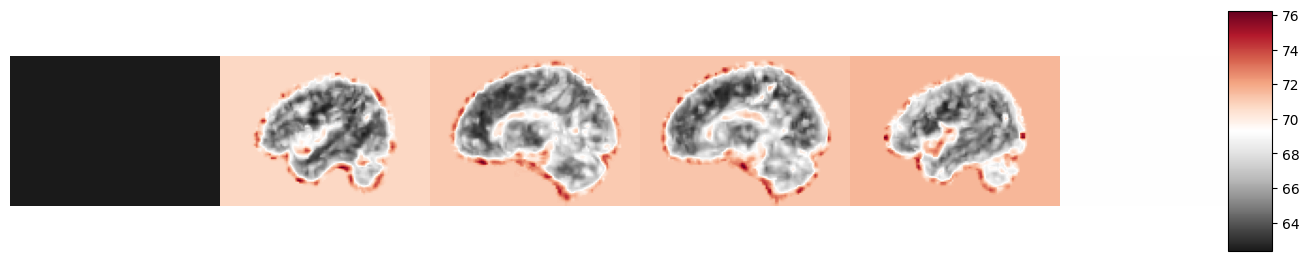

In [241]:
x = registered_heatmaps_abcd_asd_np[8]
x = x - x.min()
x = ants.from_numpy(x)
x.plot(nslices=6, cmap="RdGy_r", cbar=True)

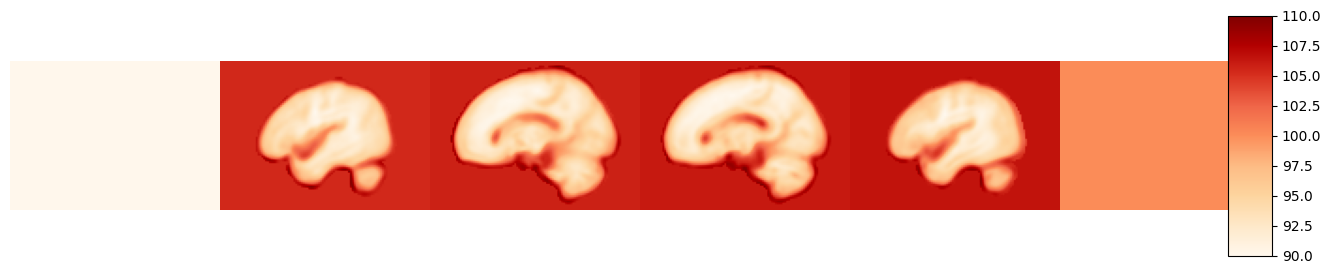

In [242]:
avg_reference_score = ants.from_numpy(np.mean(registered_heatmaps_abcd_val_test_np, axis=0))
ants.plot(image=avg_reference_score+100 , cmap="OrRd", cbar=True, nslices=6)

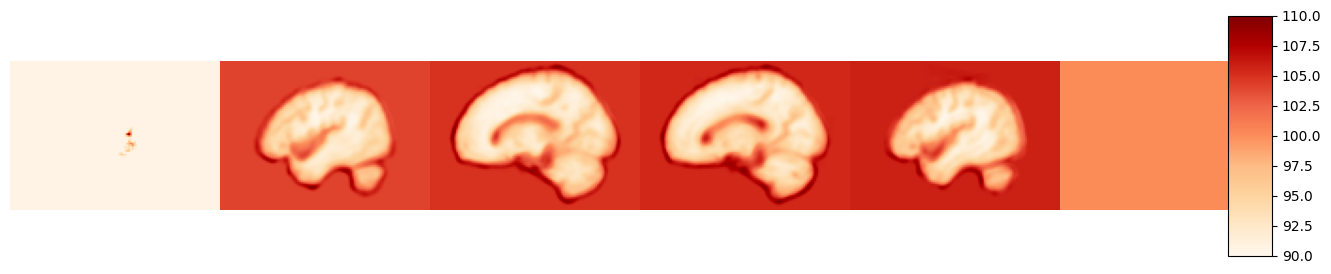

In [243]:
avg_asd_score = ants.from_numpy(np.mean(registered_heatmaps_abcd_asd_np, axis=0))
ants.plot(image=avg_asd_score+100 , cmap="OrRd", cbar=True, nslices=6)

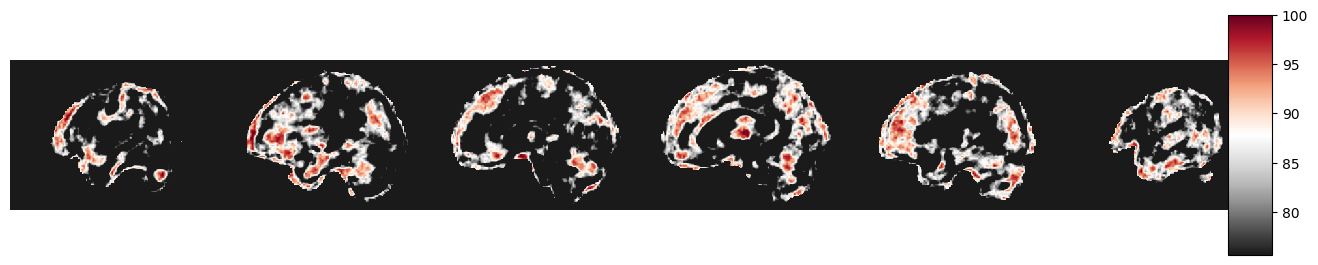

In [244]:
ds_mean = np.mean(registered_heatmaps_ibis_ds_np, axis=0)
ds_mean_pct = ants.from_numpy(vec_pscore(ds_mean, registered_heatmaps_ibis_inlier_np)[0])
# ds_mean_pct.to_filename("/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/ds_mean.nii.gz")
ants.plot(image=ds_mean_pct * BRAIN_MASK  , cmap="RdGy_r", cbar=True, nslices=6, scale=(0.5,1.0))

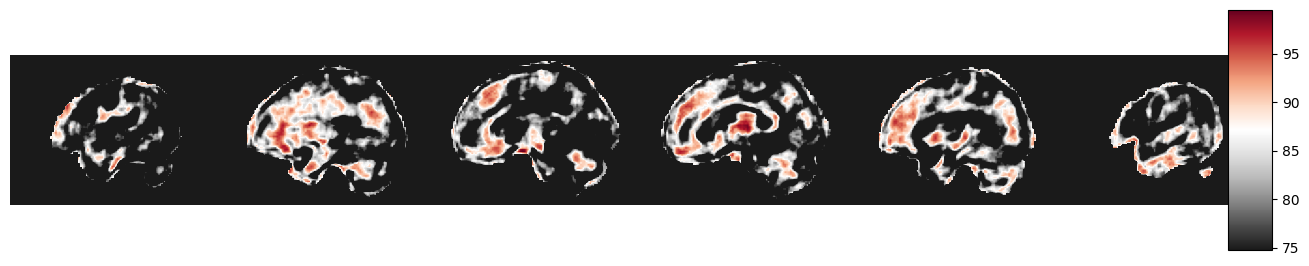

In [245]:
ds_mean = np.mean(registered_heatmaps_ibis_ds_np, axis=0)
ds_mean_pct = ants.from_numpy(vec_pscore(ds_mean, np.concatenate((registered_heatmaps_abcd_val_test_np,registered_heatmaps_ibis_inlier_np), axis=0))[0])
# ds_mean_pct.to_filename("/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/ds_mean.nii.gz")
ants.plot(image=ds_mean_pct * BRAIN_MASK  , cmap="RdGy_r", cbar=True, nslices=6, scale=(0.5,1.0))

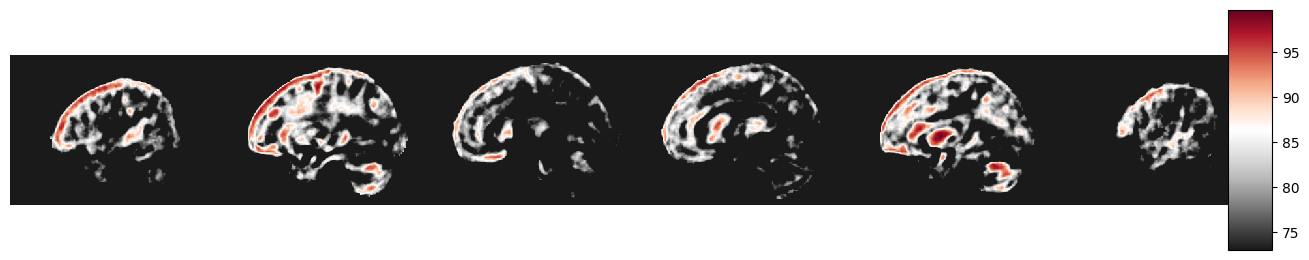

In [246]:
ds_mean = np.mean(registered_heatmaps_abcd_asd_np, axis=0)
ds_mean_pct = ants.from_numpy(vec_pscore(ds_mean, (registered_heatmaps_abcd_val_test_np))[0])
# ds_mean_pct.to_filename("/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/ds_mean.nii.gz")
ants.plot(image=ds_mean_pct * BRAIN_MASK  , cmap="RdGy_r", cbar=True, nslices=6, scale=(0.5,1.0))

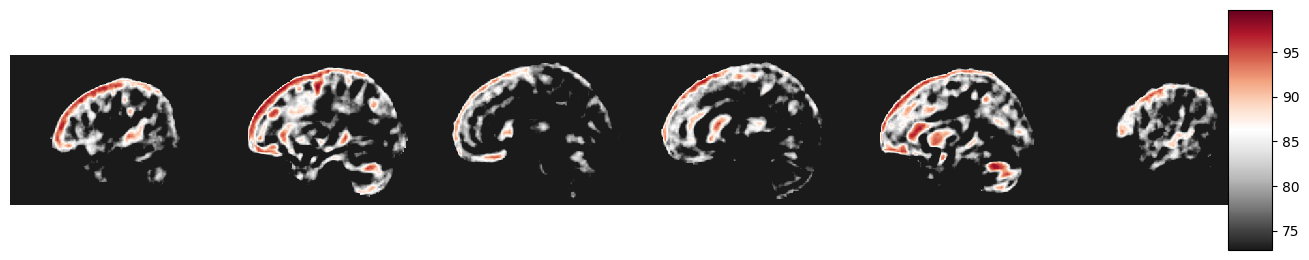

In [247]:
ds_mean = np.mean(registered_heatmaps_abcd_asd_np, axis=0)
ds_mean_pct = ants.from_numpy(vec_pscore(ds_mean, np.concatenate((registered_heatmaps_abcd_val_test_np,registered_heatmaps_ibis_inlier_np), axis=0))[0])
# ds_mean_pct.to_filename("/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/ds_mean.nii.gz")
ants.plot(image=ds_mean_pct * BRAIN_MASK  , cmap="RdGy_r", cbar=True, nslices=6, scale=(0.5,1.0))

In [248]:
reference_scores = registered_heatmaps_abcd_val_test_np #np.concatenate((registered_heatmaps_abcd_val_test_np,registered_heatmaps_ibis_inlier_np), axis=0)

# Getting Parcellation Scores 

### Using AntsPyNet deep learning model based parcellation

##### This block is all about getting a Desikan–Killiany–Tourville (DKT) cortical label map that’s in the exact same cropped/resampled grid as your ANTs reference image—and caching it so you only ever run the network once.

##### desikan_killiany_tourville_labeling is part of ANTsPyNet and produces a label image where each integer voxel value corresponds to one of the DKT cortical ROIs.

### If "DKT" atlas is used

In [ ]:
%%time
# Should only need to do this once...
dkt_precomputed_path = "../braintypicality/dataset/template_cache/dkt.nii.gz"
if os.path.exists(dkt_precomputed_path):
    dkt_raw = ants.image_read(dkt_precomputed_path)
else:
    t1_ref_img, _ = ants.image_read(procd_ref_img_path).split_channels()
    dkt_raw = antspynet.utilities.desikan_killiany_tourville_labeling(t1_ref_img, do_preprocessing=True, verbose=False)
    dkt_raw.to_filename(dkt_precomputed_path)

dkt_post = img_and_label_loader({"image": procd_ref_img_path, "label": dkt_precomputed_path})["label"][0].numpy()
dkt_post = ants.from_numpy(dkt_post)

CPU times: user 10.8 s, sys: 538 ms, total: 11.4 s
Wall time: 1.28 s


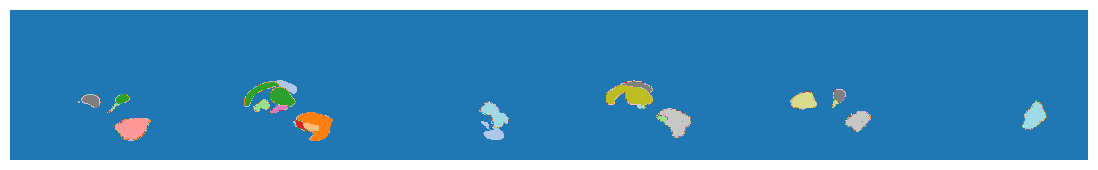

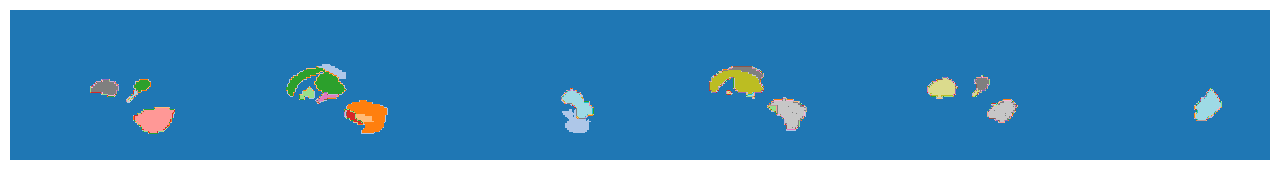

In [250]:
(dkt_raw * (dkt_raw < 1000)).plot(cmap="tab20", nslices=6)
(dkt_post * (dkt_post < 1000)).plot(cmap="tab20", nslices=6)

In [ ]:
path_dkt_labels_yaml = "../braintypicality/workdir/cuda_opt/learnable/eval/dkt_labels.yaml"

with open(path_dkt_labels_yaml, "r") as f:
    dkt_labels = yaml.safe_load(f)

dkt_labels_flattened = {k:v for regions, labels in dkt_labels.items() for k,v in labels.items()}
len(dkt_labels_flattened)

102

In [252]:
CSF = 1

In [ ]:
atropos_precomputed_path = "../braintypicality/dataset/template_cache/atropos.nii.gz"
if os.path.exists(atropos_precomputed_path):
    atropos = ants.image_read(atropos_precomputed_path)
else:
    t1_ref_img, _ = ants.image_read(procd_ref_img_path).split_channels()
    atropos = antspynet.utilities.deep_atropos(t1_ref_img, do_preprocessing=True, verbose=False)
    atropos['segmentation_image'].to_filename(atropos_precomputed_path)
    x = atropos['probability_images'][1]
    x.plot(cmap="jet", cbar=True)

In [254]:
#%%time
atropos_img = ants.resample_image(atropos, ref_img_post_transform.shape, use_voxels=True, interp_type=1)
atropos_img.set_spacing((1.0,1.0,1.0))
reg_dict = ants.registration(fixed=ref_img_post_transform, moving=atropos_img,
                             type_of_transform = 'SyN', interpolator="nearest")
atropos_transformed = ants.apply_transforms(
        fixed=ref_img_post_transform, moving=atropos_img,
        transformlist=reg_dict["fwdtransforms"], interpolator="multiLabel",
    verbose=True
)
atropos_transformed

['-d', '3', '-i', '0x7f0c1015c9e8', '-o', '0x7f075d572608', '-r', '0x7f0c1015d1c8', '-n', 'multiLabel', '-t', '/tmp/tmp7e7xa6vm1Warp.nii.gz', '-t', '/tmp/tmp7e7xa6vm0GenericAffine.mat']
Using double precision for computations.
Input scalar image: 0x7f0c1015c9e8
Could not create ImageIO for the input file, assuming dimension = 3 and scalar pixel type
Reference image: 0x7f0c1015d1c8
The composite transform comprises the following transforms (in order): 
  1. /tmp/tmp7e7xa6vm0GenericAffine.mat (type = AffineTransform)
  2. /tmp/tmp7e7xa6vm1Warp.nii.gz (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LabelImageGaussianInterpolateImageFunction
Output warped image: 0x7f075d572608


ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [255]:
atropos_post = img_and_label_loader({"image": procd_ref_img_path, "label": atropos_precomputed_path})["label"][0].numpy()
atropos_post = ants.from_numpy(atropos_post)
atropos_post

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

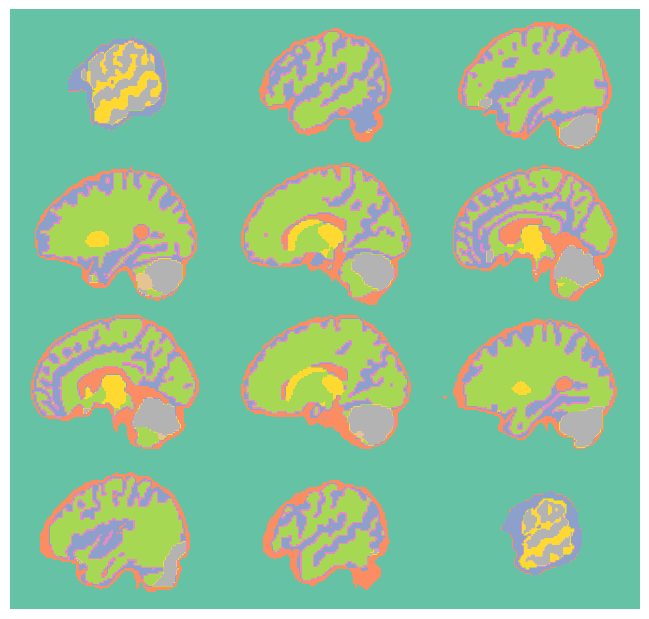

In [256]:
atropos_post.plot(cmap="Set2")

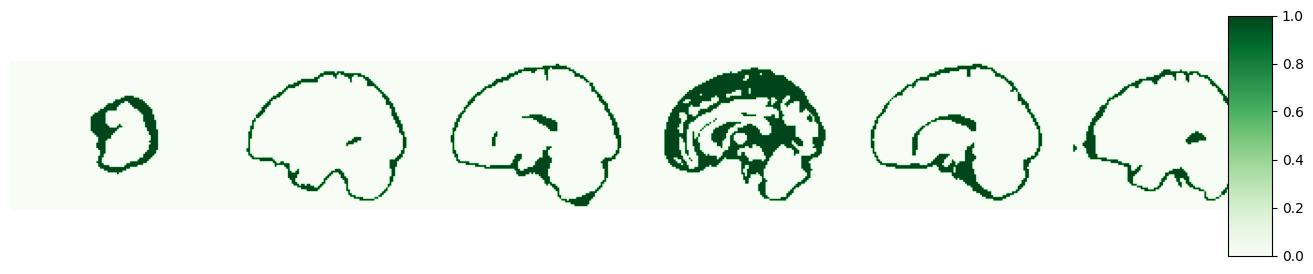

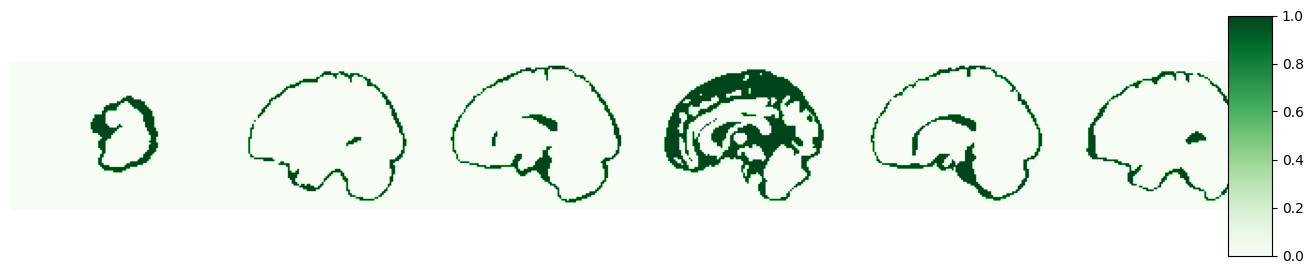

In [257]:
plotslices = [16,32,40,48,56,64]
(atropos_post * (atropos_post == CSF)).plot(cmap="Greens", cbar=True, slices=plotslices)
(atropos_post * ((atropos_post*BRAIN_MASK) == CSF)).plot(cmap="Greens", cbar=True, slices=plotslices)

### Using Atlases

/ASD2/emre_projects/miniconda3/envs/myenv/lib/python3.12/site-packages/nilearn/datasets/atlas.py:1307: DeprecationWarning: Starting in version 0.13, the default fetched mask will beAAL 3v2 instead.
  warnings.warn(message, DeprecationWarning)


[get_dataset_dir] Dataset found in 
/ASD2/emre_projects/OOD/braintypicality2/braintypicality/dataset/template_cache/atlases/aal_SPM12

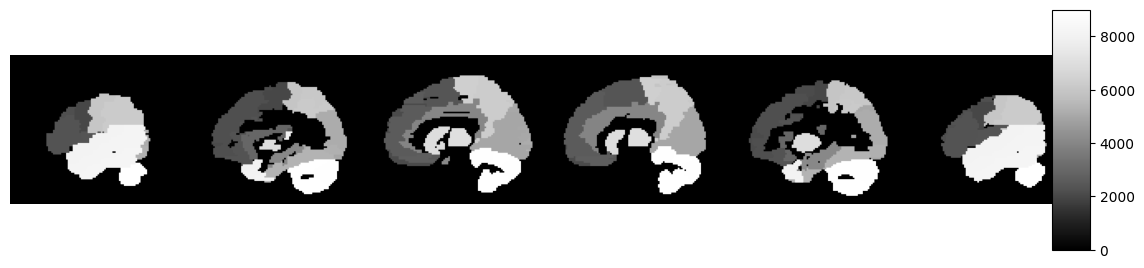

In [258]:
aal = datasets.fetch_atlas_aal(version='SPM12', data_dir=os.path.join(CACHE_DIR,"atlases"))
aal_img = ants.image_read(aal.maps, pixeltype='unsigned int')
aal_img.set_spacing((1.0,1.0,1.0))
aal_img.plot(nslices=6, cbar=True)

In [259]:
aal_img

ANTsImage (RPI)
	 Pixel Type : unsigned int (uint32)
	 Components : 1
	 Dimensions : (91, 109, 91)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [260]:
%ls $CACHE_DIR

/ASD2/emre_projects/miniconda3/envs/myenv/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=4135827) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


atlases/                     croppedMni152Priors.nii.gz
atropos.nii.gz               cropped_niral_mni.nii.gz
brainExtraction.h5           cropped_niral_mni-v1.nii.gz
brainExtractionNoBrainer.h5  dkt.nii.gz
brainExtractionRobustT1.h5   mni_icbm152_09a/
brainExtractionRobustT2.h5   ref_brain.npy
brainExtractionT1v1.h5       sixTissueOctantBrainSegmentationWithPriors1.h5
brainExtractionT2.h5         S_template3.nii.gz
croppedMni152.nii.gz


In [261]:
label_df = pd.DataFrame(aal.labels, aal.indices, columns=['ROI-Name'])
#label_df.to_csv('aal_labels.csv', index_label='ROI-Index')

In [262]:
reg_dict = ants.registration(fixed=ref_img_post_transform, moving=aal_img,
                             type_of_transform = 'SyN', interpolator="nearest")
aal_transformed = ants.apply_transforms(
        fixed=ref_img_post_transform, moving=aal_img,
        transformlist=reg_dict["fwdtransforms"], interpolator="multiLabel",
    verbose=True
)
aal_transformed

['-d', '3', '-i', '0x7f075d6c2648', '-o', '0x7f075d6c2ec8', '-r', '0x7f075d6c26c8', '-n', 'multiLabel', '-t', '/tmp/tmprl2w97mk1Warp.nii.gz', '-t', '/tmp/tmprl2w97mk0GenericAffine.mat']
Using double precision for computations.
Input scalar image: 0x7f075d6c2648
Could not create ImageIO for the input file, assuming dimension = 3 and scalar pixel type
Reference image: 0x7f075d6c26c8
The composite transform comprises the following transforms (in order): 
  1. /tmp/tmprl2w97mk0GenericAffine.mat (type = AffineTransform)
  2. /tmp/tmprl2w97mk1Warp.nii.gz (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LabelImageGaussianInterpolateImageFunction
Output warped image: 0x7f075d6c2ec8


ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

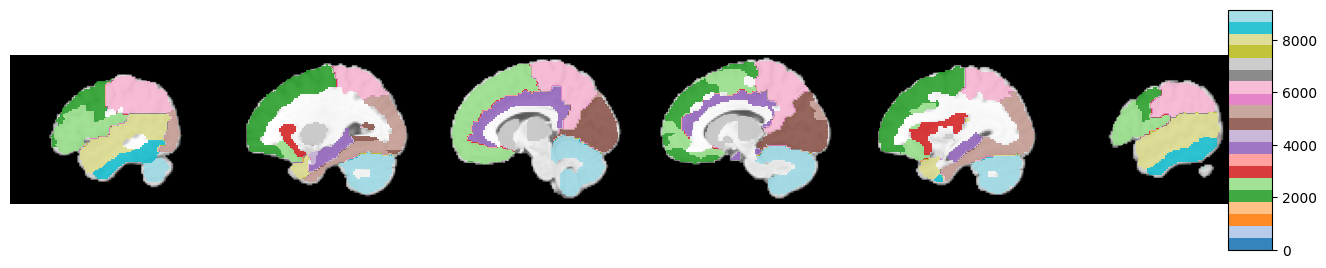

In [263]:
ref_img_post_transform.plot(overlay=aal_transformed, nslices=6, cbar=True, overlay_cmap="tab20")

6001 Postcentral_L


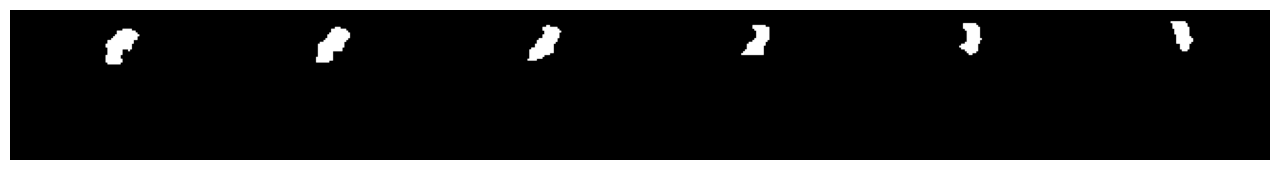

In [264]:
for indx, label in zip(aal.indices, aal.labels):
    if int(indx) < 6000: continue
    print(indx, label)
    (aal_transformed*((aal_transformed == int(indx))*1.0)).plot(nslices=6)
    break

[get_dataset_dir] Dataset found in 
/ASD2/emre_projects/OOD/braintypicality2/braintypicality/dataset/template_cache/atlases/fsl

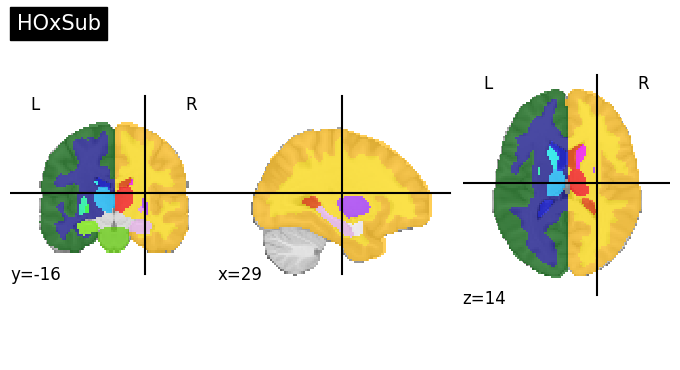

In [265]:
atlas_name = 'sub-maxprob-thr25-2mm'
harvard_oxford_subcortical = datasets.fetch_atlas_harvard_oxford(atlas_name, data_dir=os.path.join(CACHE_DIR,"atlases"))
plotting.plot_roi(harvard_oxford_subcortical.maps, title="HOxSub")

['-d', '3', '-i', '0x7f075d69ad48', '-o', '0x7f075d69a448', '-r', '0x7f075d69a488', '-n', 'multiLabel', '-t', '/tmp/tmpylkyldtb1Warp.nii.gz', '-t', '/tmp/tmpylkyldtb0GenericAffine.mat']
Using double precision for computations.
Input scalar image: 0x7f075d69ad48
Could not create ImageIO for the input file, assuming dimension = 3 and scalar pixel type
Reference image: 0x7f075d69a488
The composite transform comprises the following transforms (in order): 
  1. /tmp/tmpylkyldtb0GenericAffine.mat (type = AffineTransform)
  2. /tmp/tmpylkyldtb1Warp.nii.gz (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LabelImageGaussianInterpolateImageFunction
Output warped image: 0x7f075d69a448


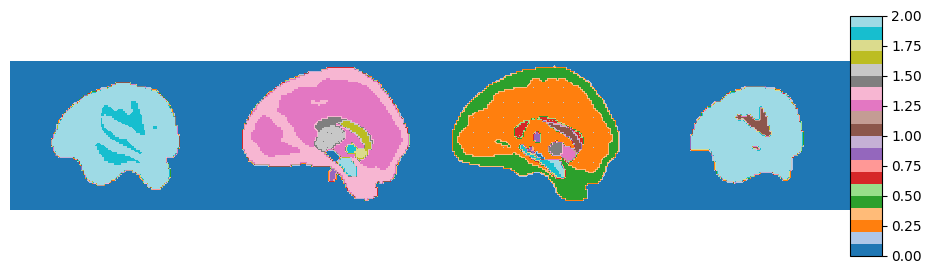

In [266]:
#harvard_subcortical_labels = ants.from_nibabel(harvard_oxford_subcortical.maps)

# nibabel image
nib_img = harvard_oxford_subcortical.maps
# grab the raw data and voxel spacing
data = nib_img.get_fdata(dtype=np.float32)
spacing = nib_img.header.get_zooms()[:3]

# convert into an ANTsImage
harvard_subcortical_labels = ants.from_numpy(data, spacing)

harvard_subcortical_labels.set_spacing((1.0,1.0,1.0))
reg_dict = ants.registration(fixed=ref_img_post_transform, moving=harvard_subcortical_labels,
                             type_of_transform = 'SyN', interpolator="nearest")
harvard_subcortical_labels_transformed = ants.apply_transforms(
        fixed=ref_img_post_transform, moving=harvard_subcortical_labels,
        transformlist=reg_dict["fwdtransforms"], interpolator="multiLabel",
    verbose=True
)
harvard_subcortical_labels_transformed.plot(nslices=4, cmap="tab20", cbar=True)

[get_dataset_dir] Dataset found in 
/ASD2/emre_projects/OOD/braintypicality2/braintypicality/dataset/template_cache/atlases/fsl

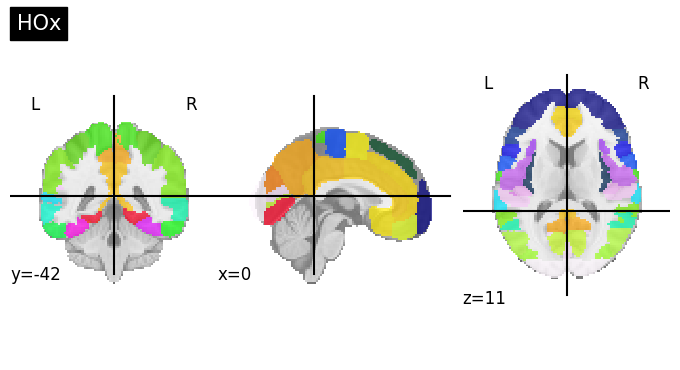

In [267]:
atlas_name = 'cort-maxprob-thr25-2mm'
harvard_oxford_cortical = datasets.fetch_atlas_harvard_oxford(atlas_name, data_dir=os.path.join(CACHE_DIR,"atlases"))
plotting.plot_roi(harvard_oxford_cortical.maps, title="HOx")

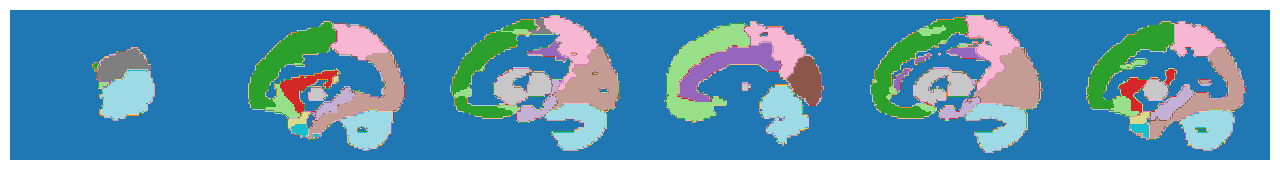

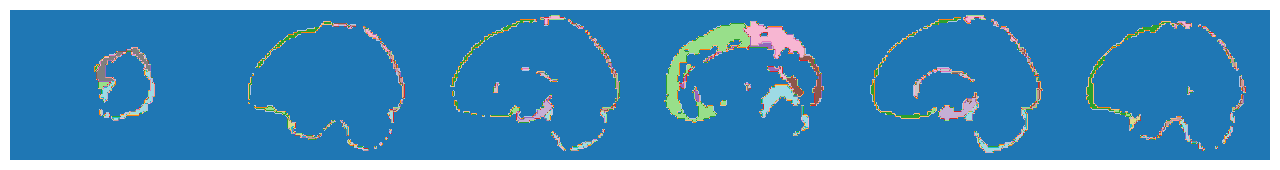

In [268]:
aal_transformed.plot(cmap="tab20",slices=plotslices)
(aal_transformed * (atropos_transformed == CSF)).plot(cmap="tab20", slices=plotslices)

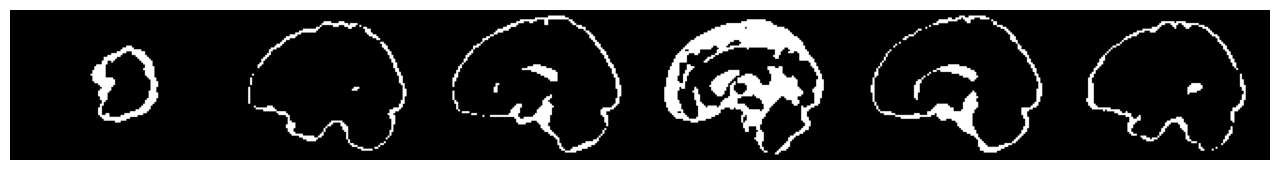

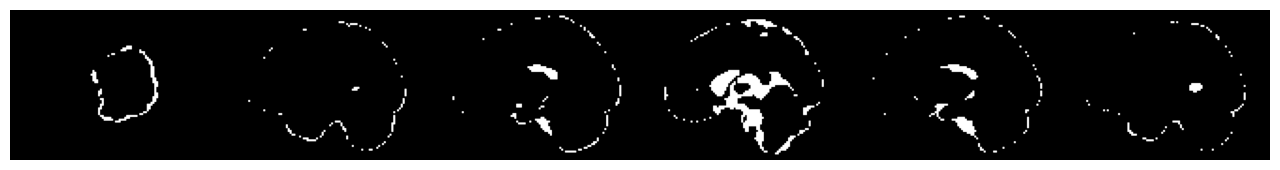

In [269]:
csf_label = (atropos_transformed  * BRAIN_MASK) == CSF
csf_label.plot(slices=plotslices)
csf_label = csf_label * (aal_transformed == 0) # Remove regions where there is an AAL labels 
csf_label.plot(slices=plotslices)

In [270]:
ATLAS = "AAL+CSF"

match ATLAS:
    case "AAL":
        parcellation = aal_transformed.numpy().astype(int)
        parcellation_labels_map = {int(k):v for k,v in zip(aal.indices,aal.labels)}
        # Manually adding background
        parcellation_labels_map[0] = "background"
        parcellation_indices = np.unique(parcellation)
    case "AAL+CSF":
        parcellation = aal_transformed.numpy().astype(int)
        parcellation_labels_map = {int(k):v for k,v in zip(aal.indices,aal.labels)}
        
        # Manually adding background + CSF
        parcellation_labels_map[0] = "background"
        
        # Including deep atropos CSF segmentation
        csf_label = (atropos_transformed  * BRAIN_MASK) == CSF
        csf_label = csf_label.numpy().astype(int)
        # Remove regions where there is an AAL labels 
        parcellation = csf_label * (parcellation == 0) + parcellation
        # I checked - there is n o label "1" in the given AAL
        parcellation_labels_map[1] = "CSF"
        
        parcellation_indices = np.unique(parcellation)
        
    case "AAL+Harvard":
        parcellation = aal_transformed.numpy().astype(int)
        subcorticals = harvard_subcortical_labels_transformed.numpy().astype(int)

        subcortical_mask = np.ones_like(subcorticals)
        skip_labels = [0,1,2, 12,13] # These look like cortical regions
        for i in skip_labels:
            subcortical_mask[subcortical_mask==i] = 0
        subcort_mask = subcortical_mask > 0

        parcellation = parcellation * ~subcort_mask + subcorticals * subcort_mask

        parcellation_labels_map = {int(k):v for k,v in zip(aal.indices,aal.labels)}
        for i,label in enumerate(harvard_oxford_subcortical.labels):
            parcellation_labels_map[i] = label
        parcellation_indices = np.unique(parcellation)

    case "DKT":
        dkt_parcellation = dkt_post.numpy().astype(int)
        region_idxs = np.unique(dkt_parcellation)
    case _:
        print("SELECT VALID ATLAS")

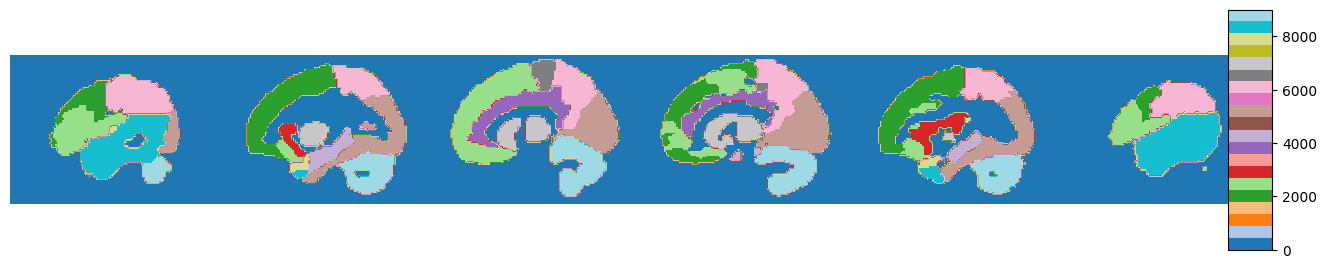

In [271]:
ants.from_numpy(parcellation.astype(float)).plot(nslices=6, cmap="tab20", cbar=True)

In [272]:
##### AntsPyNet DKT #######
# region_names = sorted(dkt_labels_flattened.values())
# reference_parcellation_scores = []

# for i, anomap in enumerate(reference_scores):
#     d = {dkt_labels_flattened[label_idx]:anomap[dkt_parcellation == label_idx].mean() for label_idx in region_idxs}
#     reference_parcellation_scores.append(d)
        
# reference_parcellation_scores = pd.DataFrame(reference_parcellation_scores)
# reference_parcellation_scores.head()

In [273]:
# parcellation_labels_map

In [274]:
len(parcellation_labels_map), len(parcellation_indices), parcellation.shape

(118, 118, (96, 112, 80))

In [275]:
np.unique(parcellation), len(np.unique(parcellation))

(array([   0,    1, 2001, 2002, 2101, 2102, 2111, 2112, 2201, 2202, 2211,
        2212, 2301, 2302, 2311, 2312, 2321, 2322, 2331, 2332, 2401, 2402,
        2501, 2502, 2601, 2602, 2611, 2612, 2701, 2702, 3001, 3002, 4001,
        4002, 4011, 4012, 4021, 4022, 4101, 4102, 4111, 4112, 4201, 4202,
        5001, 5002, 5011, 5012, 5021, 5022, 5101, 5102, 5201, 5202, 5301,
        5302, 5401, 5402, 6001, 6002, 6101, 6102, 6201, 6202, 6211, 6212,
        6221, 6222, 6301, 6302, 6401, 6402, 7001, 7002, 7011, 7012, 7021,
        7022, 7101, 7102, 8101, 8102, 8111, 8112, 8121, 8122, 8201, 8202,
        8211, 8212, 8301, 8302, 9001, 9002, 9011, 9012, 9021, 9022, 9031,
        9032, 9041, 9042, 9051, 9052, 9061, 9062, 9071, 9072, 9081, 9082,
        9100, 9110, 9120, 9130, 9140, 9150, 9160, 9170]),
 118)

In [276]:
#%%time
region_names = sorted(parcellation_labels_map.values())
reference_parcellation_scores = []

for i, anomap in enumerate(reference_scores):
    d = {parcellation_labels_map[label_idx]: anomap[parcellation == label_idx].mean() for label_idx in parcellation_indices}
    reference_parcellation_scores.append(d)
        
reference_parcellation_scores = pd.DataFrame(reference_parcellation_scores)
reference_parcellation_scores.head()

,background,CSF,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,...,Cerebelum_10_L,Cerebelum_10_R,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10
0,-2.326570,-4.546085,-36.237423,-35.016743,-30.232557,-31.747337,-19.677507,-18.442070,-31.710230,-33.367962,...,-10.319971,-6.203157,-3.671109,-8.667409,-20.428837,-25.400295,-31.290211,-33.989334,-28.532587,6.611611
1,-2.238010,-2.490152,-32.156513,-30.772257,-26.611935,-28.134436,-15.838318,-9.409232,-30.019289,-27.938967,...,-0.429158,-5.583305,-7.253343,-2.896818,-25.083933,-18.860655,-19.607904,-20.393875,-26.772461,-1.863146
2,-2.169739,-0.678283,-36.185955,-34.284267,-33.005424,-32.619606,-20.074854,-18.300592,-34.569817,-33.475266,...,-10.957269,-2.547339,5.891078,-7.579268,-21.371614,-25.460165,-24.320648,-18.033197,-18.352684,13.469888
3,-2.212189,0.737401,-32.341423,-32.415279,-25.921171,-28.079033,-12.995010,-13.137298,-28.408182,-28.071743,...,3.170770,-0.832582,-0.506636,-16.087933,-17.375572,-26.444271,-21.143147,-19.345272,-16.664568,4.753420
4,-2.162377,-2.506347,-33.838276,-33.660507,-32.421467,-33.776905,-19.803349,-17.127913,-30.890854,-32.550747,...,-3.575296,-8.992916,3.921495,-4.097315,-10.982370,-14.925224,-22.937826,-24.738998,-18.974272,10.858388


In [277]:
#reference_parcellation_scores.to_csv(f"{workdir}/eval/heatmaps_v2/roi/training-{ATLAS}_roi_likelihoods.csv", index=None)

In [278]:
workdir

'/ASD2/emre_projects/OOD/braintypicality2/braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct/'

In [279]:
reference_parcellation_scores["CSF"].describe()

count    330.000000
mean      -2.191503
std        1.903892
min       -6.224301
25%       -3.662878
50%       -2.329445
75%       -1.007794
max        4.447678
Name: CSF, dtype: float64

In [280]:
percentileofscore(reference_parcellation_scores["CSF"], 2.0)

97.57575757575758

In [283]:
cohort_data = {
    "IBIS-DS": (ibis_ds_files, registered_heatmaps_ibis_ds_np),
    "IBIS-LR-Typical": (ibis_inlier_files, registered_heatmaps_ibis_inlier_np),
    "IBIS-HR-Typical": (ibis_hr_files, registered_heatmaps_ibis_hr_inlers_np),
    "IBIS-Atypical": (ibis_atyp_files, registered_heatmaps_ibis_atypical_np),
    "IBIS-ASD": (ibis_asd_files, registered_heatmaps_ibis_asd_np),
    "ABCD-ASD": (abcd_asd_files, registered_heatmaps_abcd_asd_np),
    "ABCD-Val-Test": (abcd_val_test_files, registered_heatmaps_abcd_val_test_np),
    "CONTE": (conte_files, registered_heatmaps_conte_np)
}

In [285]:
#%%time

region_scores = []
region_raw_likelihoods = []
columns = [parcellation_labels_map[label_idx] for label_idx in parcellation_indices]
columns = columns + ['Cohort', "ID"]

for cohort, (filenames, scores) in cohort_data.items():
    for i, anomap in enumerate(scores):
        score_row, raw_row = [], []

        for label_idx in parcellation_indices:
            roi_name = parcellation_labels_map[label_idx]
            raw_mean = anomap[parcellation == label_idx].mean()
            pct_score = percentileofscore(reference_parcellation_scores[roi_name], raw_mean)
            score_row.append(pct_score)
            raw_row.append(raw_mean)
        
        sid = extract_ids(filenames[i]['image'])
        score_row.append(cohort)
        score_row.append(sid)
        region_scores.append(score_row)
        
        raw_row.append(cohort)
        raw_row.append(sid)
        region_raw_likelihoods.append(raw_row)

region_scores = pd.DataFrame(region_scores, columns=columns)
region_scores_raw = pd.DataFrame(region_raw_likelihoods, columns=columns)
region_scores.head()

,background,CSF,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,...,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10,Cohort,ID
0,100.000000,100.000000,99.696970,100.000000,100.000000,99.393939,99.393939,98.484848,99.393939,99.696970,...,13.939394,24.242424,89.393939,93.030303,82.121212,97.878788,74.848485,65.757576,IBIS-DS,IBIS105477
1,97.878788,97.575758,77.878788,90.606061,94.242424,97.878788,99.090909,99.090909,96.666667,99.393939,...,31.818182,16.363636,22.121212,43.939394,43.939394,49.696970,34.848485,33.030303,IBIS-DS,IBIS110925
2,88.484848,96.060606,23.939394,29.393939,46.363636,40.909091,80.000000,61.212121,60.909091,36.363636,...,6.969697,27.272727,12.424242,23.636364,56.363636,41.515152,71.212121,50.000000,IBIS-DS,IBIS123451
3,98.787879,97.575758,95.151515,98.787879,97.272727,98.484848,94.242424,89.696970,97.878788,98.787879,...,34.545455,12.424242,72.727273,91.212121,28.787879,10.606061,23.030303,53.939394,IBIS-DS,IBIS146443
4,96.969697,95.757576,64.545455,84.242424,96.969697,97.272727,89.696970,98.484848,96.363636,96.969697,...,3.939394,56.969697,69.393939,74.242424,87.272727,92.424242,19.393939,36.969697,IBIS-DS,IBIS241887


In [286]:
region_scores_raw.shape

(1254, 120)

### SAVE ROI SCORES

In [ ]:
workdir = "../braintypicality/workdir/cuda_opt/learnable"
# save
#region_scores_raw.to_csv(f"{workdir}/eval/heatmaps_v2/roi/{ATLAS}_roi_likelihoods_abcd_ibis_conte.csv", index=None)

In [288]:
# region_scores.to_csv(f"{workdir}/eval/heatmaps_v2/roi/{ATLAS}_roi_scores.csv", index=None)

In [ ]:
%ls -ailh ../braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/roi/

/ASD2/emre_projects/miniconda3/envs/myenv/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=4135827) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


total 1.5M
17181880799 drwxr-xr-x. 2 amahmood root 4.0K Apr  8  2024 ./
14509287652 drwxr-xr-x. 5 amahmood root 4.0K Mar 14  2024 ../
17185952746 -rw-r--r--. 1 amahmood root 404K Apr  3  2024 AAL+CSF_roi_likelihoods.csv
17181889637 -rw-r--r--. 1 amahmood root 663K Mar 12  2024 AAL+CSF_roi_scores.csv
17184858574 -rw-r--r--. 1 amahmood root 410K Apr  8  2024 training-AAL+CSF_roi_likelihoods.csv


In [ ]:
%ls -ailh ../braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/roi/

total 4.1M
 5191766752 drwxr-xr-x. 2 emreone res 4.0K Apr 24 22:30 ./
37336798808 drwxr-xr-x. 5 emreone res 4.0K Mar 14  2024 ../
 5307239751 -rw-rw-r--. 1 emreone res 1.6M Apr 24 22:30 AAL+CSF_roi_likelihoods_abcd_ibis_conte.csv
 5307239749 -rw-rw-r--. 1 emreone res 1.0M Apr 24 21:28 AAL+CSF_roi_likelihoods_abcd_ibis.csv
 5191953607 -rw-r--r--. 1 emreone res 404K Apr  3  2024 AAL+CSF_roi_likelihoods.csv
 5191953608 -rw-r--r--. 1 emreone res 663K Mar 12  2024 AAL+CSF_roi_scores.csv
 5191953609 -rw-r--r--. 1 emreone res 410K Apr  8  2024 training-AAL+CSF_roi_likelihoods.csv


In [291]:
region_scores

,background,CSF,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,...,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10,Cohort,ID
0,100.000000,100.000000,99.696970,100.000000,100.000000,99.393939,99.393939,98.484848,99.393939,99.696970,...,13.939394,24.242424,89.393939,93.030303,82.121212,97.878788,74.848485,65.757576,IBIS-DS,IBIS105477
1,97.878788,97.575758,77.878788,90.606061,94.242424,97.878788,99.090909,99.090909,96.666667,99.393939,...,31.818182,16.363636,22.121212,43.939394,43.939394,49.696970,34.848485,33.030303,IBIS-DS,IBIS110925
2,88.484848,96.060606,23.939394,29.393939,46.363636,40.909091,80.000000,61.212121,60.909091,36.363636,...,6.969697,27.272727,12.424242,23.636364,56.363636,41.515152,71.212121,50.000000,IBIS-DS,IBIS123451
3,98.787879,97.575758,95.151515,98.787879,97.272727,98.484848,94.242424,89.696970,97.878788,98.787879,...,34.545455,12.424242,72.727273,91.212121,28.787879,10.606061,23.030303,53.939394,IBIS-DS,IBIS146443
4,96.969697,95.757576,64.545455,84.242424,96.969697,97.272727,89.696970,98.484848,96.363636,96.969697,...,3.939394,56.969697,69.393939,74.242424,87.272727,92.424242,19.393939,36.969697,IBIS-DS,IBIS241887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,95.757576,99.393939,94.242424,100.000000,99.393939,99.393939,97.272727,98.484848,99.090909,99.696970,...,0.000000,9.696970,6.363636,8.181818,26.363636,10.303030,6.060606,17.878788,CONTE,TWINST0324-1-2
1250,99.393939,100.000000,99.393939,100.000000,100.000000,99.393939,100.000000,99.696970,99.393939,100.000000,...,0.000000,0.606061,0.000000,12.727273,19.393939,55.454545,25.757576,11.212121,CONTE,TWINST0325-1-1
1251,99.696970,100.000000,100.000000,100.000000,100.000000,100.000000,99.696970,99.393939,100.000000,100.000000,...,3.939394,0.606061,25.757576,0.606061,17.575758,22.424242,3.333333,34.545455,CONTE,TWINST0325-1-2
1252,100.000000,99.696970,99.696970,100.000000,100.000000,99.393939,97.272727,93.939394,99.393939,99.393939,...,87.575758,97.272727,90.606061,26.363636,78.484848,95.151515,62.121212,69.090909,CONTE,TWINST0326-1-1


In [292]:
region_scores_raw

,background,CSF,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,...,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10,Cohort,ID
0,-1.414520,4.935915,-23.396759,-20.194393,-16.253609,-18.492374,-6.100228,-4.667475,-18.205803,-17.272818,...,-7.965966,-13.257126,-15.161258,-17.249840,-21.547440,-15.184226,-16.114609,8.613302,IBIS-DS,IBIS105477
1,-1.755531,1.930630,-31.382809,-28.592943,-22.649532,-21.717169,-7.335914,-3.340267,-23.636929,-19.701454,...,-5.061921,-14.594221,-23.457136,-24.472313,-27.605259,-26.630812,-21.580175,2.596993,IBIS-DS,IBIS110925
2,-2.013648,1.181434,-34.911354,-34.427402,-28.812599,-30.537939,-14.334145,-15.506088,-29.821947,-31.357674,...,-9.439909,-12.790636,-24.681688,-26.850214,-26.089520,-27.550220,-16.725264,5.595393,IBIS-DS,IBIS123451
3,-1.718941,2.047871,-27.545654,-24.831266,-20.921286,-21.347919,-11.048391,-11.258459,-21.755131,-22.207550,...,-4.746197,-15.163088,-18.174290,-17.746424,-29.122190,-31.439083,-23.795202,6.414294,IBIS-DS,IBIS146443
4,-1.824175,1.011971,-32.457405,-29.960211,-21.052862,-22.551779,-12.599647,-7.953003,-24.247021,-23.142988,...,-11.014130,-9.073844,-18.646622,-20.803654,-20.289297,-19.982325,-24.603029,3.385677,IBIS-DS,IBIS241887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,-1.876805,4.080798,-27.895708,-21.019157,-18.800034,-18.027008,-9.247251,-6.536561,-20.434912,-17.409348,...,-20.243448,-15.978193,-25.849073,-29.740911,-29.507376,-31.519413,-27.427294,-1.094159,CONTE,TWINST0324-1-2
1250,-1.697448,6.331012,-24.434713,-21.067200,-14.013192,-14.818054,-0.384970,-0.451501,-17.071871,-13.266597,...,-18.378462,-20.246702,-28.303101,-28.423639,-30.930275,-26.108940,-23.343975,-2.653356,CONTE,TWINST0325-1-1
1251,-1.611626,5.654150,-22.363150,-18.485533,-13.729199,-12.918817,-3.509538,-1.253298,-14.699400,-11.611748,...,-10.894036,-19.964375,-22.973852,-32.618149,-31.161097,-29.589369,-28.425081,2.754895,CONTE,TWINST0325-1-2
1252,-1.246378,4.429859,-23.335770,-22.980043,-14.560200,-15.633745,-9.386684,-9.760300,-18.029383,-20.674435,...,4.879560,0.995235,-14.294279,-26.477581,-22.436289,-19.039490,-17.851343,9.399012,CONTE,TWINST0326-1-1


In [293]:
cohort_means = region_scores_raw.pivot(columns='Cohort').mean(numeric_only=True)
diff = cohort_means.loc[:,'IBIS-DS']-cohort_means.loc[:,'IBIS-LR-Typical']
diff

background       0.300319
CSF              4.447944
Precentral_L     3.959709
Precentral_R     4.715712
Frontal_Sup_L    6.096102
                   ...   
Vermis_6         6.516293
Vermis_7         5.925333
Vermis_8         5.492161
Vermis_9         4.975517
Vermis_10        3.933308
Length: 118, dtype: float32

In [294]:
# inner_regions = list(filter(lambda c: c in dkt_labels["Inner labels"].values(),  region_scores.columns))
# sorted_regions = list(region_scores.query("Cohort == 'IBIS-DS'")[inner_regions].mean().sort_values(ascending=False).index)

In [295]:
sorted_regions = list(diff.sort_values(ascending=False).index)
inner_scores = region_scores_raw[sorted_regions+["Cohort"]]
data = inner_scores.melt(id_vars="Cohort", var_name="Region", value_name="Anomaly Score")
data.head()

,Cohort,Region,Anomaly Score
0,IBIS-DS,Frontal_Mid_Orb_R,-3.344497
1,IBIS-DS,Frontal_Mid_Orb_R,-6.736537
2,IBIS-DS,Frontal_Mid_Orb_R,-14.841328
3,IBIS-DS,Frontal_Mid_Orb_R,-13.520341
4,IBIS-DS,Frontal_Mid_Orb_R,-8.604696


[Text(0, 0, 'Vermis_6'),
 Text(1, 0, 'Occipital_Mid_R'),
 Text(2, 0, 'Frontal_Inf_Tri_R'),
 Text(3, 0, 'Frontal_Sup_Orb_L'),
 Text(4, 0, 'Hippocampus_L'),
 Text(5, 0, 'Cerebelum_6_L'),
 Text(6, 0, 'Temporal_Mid_R'),
 Text(7, 0, 'ParaHippocampal_L'),
 Text(8, 0, 'Temporal_Inf_R'),
 Text(9, 0, 'Thalamus_R')]

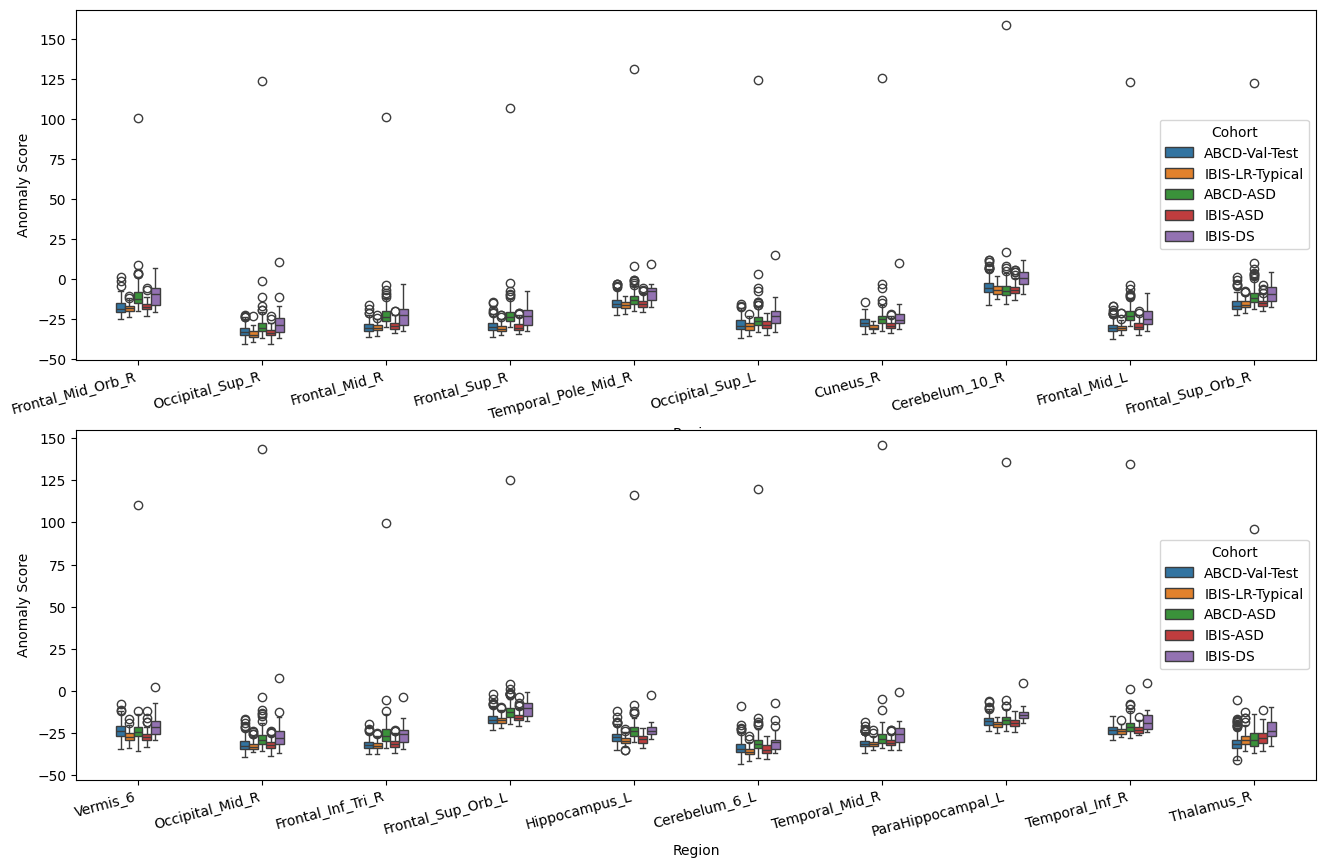

In [296]:
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(2,1, figsize=(16,10))
ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[:10])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["ABCD-Val-Test","IBIS-LR-Typical","ABCD-ASD","IBIS-ASD","IBIS-DS"], ax=axs[0],  width=0.35)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
#ax.set_ylim(-50,50)

ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[10:20])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["ABCD-Val-Test","IBIS-LR-Typical","ABCD-ASD","IBIS-ASD","IBIS-DS"], ax=axs[1],  width=0.35)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
#ax.set_ylim(-50,20)


(-45.0, 15.0)

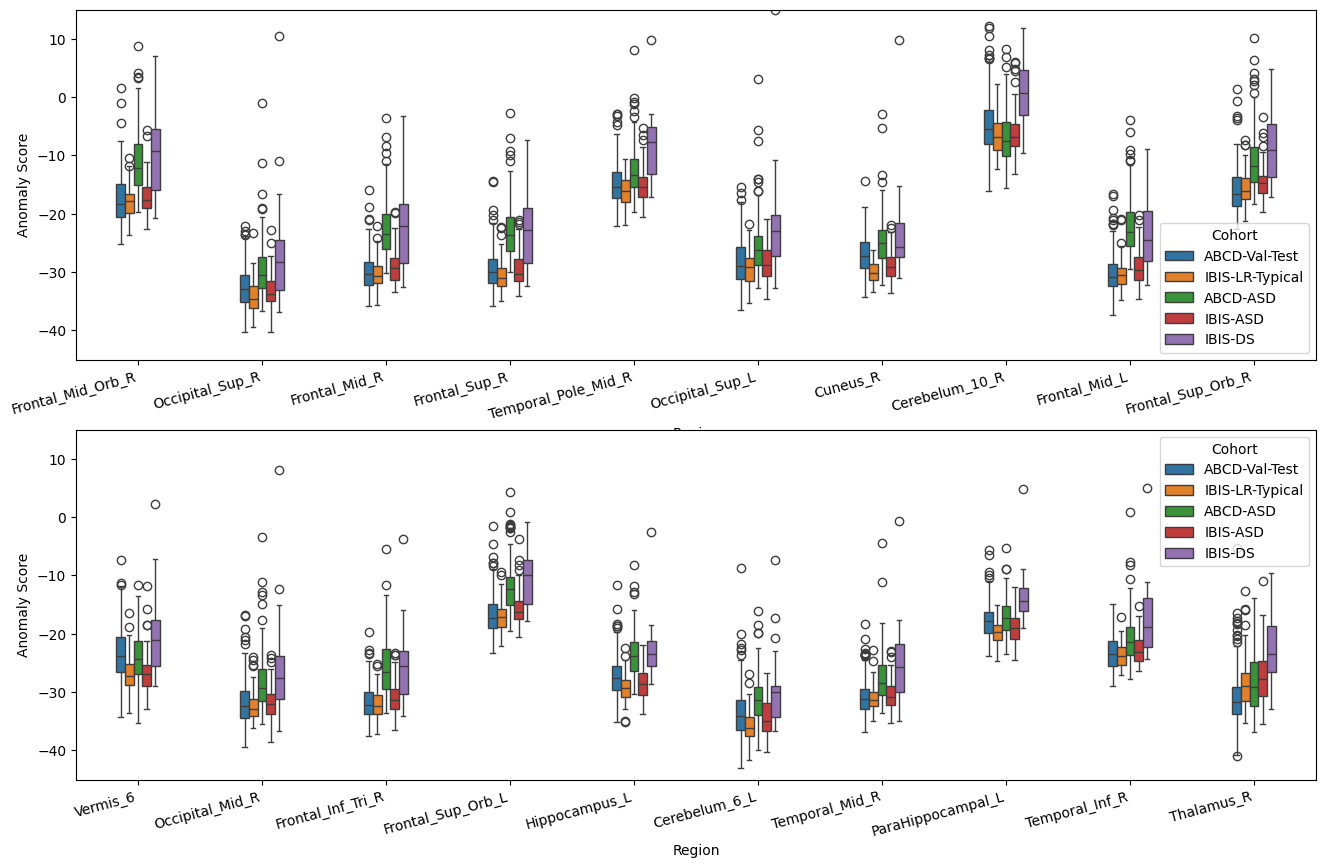

In [297]:
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(2,1, figsize=(16,10))
ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[:10])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["ABCD-Val-Test","IBIS-LR-Typical","ABCD-ASD","IBIS-ASD","IBIS-DS"], ax=axs[0],  width=0.35)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
ax.set_ylim(-45,15)

ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[10:20])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["ABCD-Val-Test","IBIS-LR-Typical","ABCD-ASD","IBIS-ASD","IBIS-DS"], ax=axs[1],  width=0.35)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
ax.set_ylim(-45,15)

### Compute Lobe Score Norms

In [ ]:
aal_lobes = pd.read_csv('../braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/aal_labels_lobe.csv')
aal_lobes

,ROI-Index,ROI-Name,Lobe,Unnamed: 3,Notes
0,2001,Precentral_L,Frontal L,NaN,NaN
1,2002,Precentral_R,Frontal R,NaN,NaN
2,2101,Frontal_Sup_L,Frontal L,NaN,NaN
3,2102,Frontal_Sup_R,Frontal R,NaN,NaN
4,2111,Frontal_Sup_Orb_L,Frontal L,NaN,NaN
...,...,...,...,...,...
111,9130,Vermis_6,Vermis,NaN,NaN
112,9140,Vermis_7,Vermis,NaN,NaN
113,9150,Vermis_8,Vermis,NaN,NaN
114,9160,Vermis_9,Vermis,NaN,NaN


In [301]:
parcellation.shape, x.shape

((96, 112, 80), (96, 112, 80))

In [302]:
x = registered_heatmaps_abcd_asd[0]

In [303]:

aal_lobes_to_index = aal_lobes.groupby('Lobe')['ROI-Index']

lobe_data = {}
for cohort, (filenames, scores) in cohort_data.items():
    cohort_likelihoods = []
    for i, anomap in enumerate(scores):
        lobe_likelihoods = []
        for lobe, roi_idxs in aal_lobes_to_index:
            lobe_ll = np.concatenate([anomap[parcellation == idx] for idx in roi_idxs])
            lobe_ll = np.mean(lobe_ll)
            lobe_likelihoods.append(lobe_ll)
        cohort_likelihoods.append(np.asarray(lobe_likelihoods))
        
    lobe_data[cohort] = np.vstack(cohort_likelihoods)

In [304]:
[l.shape for l in lobe_data.values()]

[(28, 17),
 (82, 17),
 (106, 17),
 (38, 17),
 (65, 17),
 (161, 17),
 (330, 17),
 (444, 17)]

In [305]:
#np.savez_compressed(f"{workdir}/eval/heatmaps_v2/lobe_likelihoods.npz", **lobe_data)

In [306]:
lobe_data.keys()

dict_keys(['IBIS-DS', 'IBIS-LR-Typical', 'IBIS-HR-Typical', 'IBIS-Atypical', 'IBIS-ASD', 'ABCD-ASD', 'ABCD-Val-Test', 'CONTE'])